# Usage (quick version)
This is a quick tour of CovsirPhy. Details of datasets and scenario analysis will be explained.

## Preparation
Prepare the packages.

In [1]:
# Standard users
# !pip install covsirphy

In [2]:
# Developers (Note: this notebook is in example directory)
import os
os.chdir("../")

In [3]:
import covsirphy as cs
cs.__version__

'2.10.0-zeta.new.269.319.fix.307.309.refactor.291'

## Dataset preparation
Download the datasets to "input" direcotry and load them.

If "input" directory has the datasets, `DataLoader` will load the local files. If the datasets were updated in remote servers, `DataLoader` will update the local files automatically.
Download the datasets to "input" direcotry and load them.

If "input" directory has the datasets, `DataLoader` will load the local files. If the datasets were updated in remote servers, `DataLoader` will update the local files automatically.

In [4]:
data_loader = cs.DataLoader("input")
# The number of cases (JHU style)
jhu_data = data_loader.jhu(verbose=True)
# Population in each country
population_data = data_loader.population(verbose=True)
# Government Response Tracker (OxCGRT)
oxcgrt_data = data_loader.oxcgrt(verbose=True)

Retrieving datasets from COVID-19 Data Hub: https://covid19datahub.io/



Detailed citaition list:
Open Government Data, United Kingdom (2020), https://coronavirus.data.gov.uk
Department of Disease Control of Thailand (2020), https://covid19.th-stat.com/
World Health Organization (2020), https://covid19.who.int
Ireland Health Protection Surveillance Centre (HPSC) and Health Service Executive (HSE) (2020), https://covid19ireland-geohive.hub.arcgis.com/
The COVID Tracking Project (2020), https://covidtracking.com
Ministry of Health of Croatia (2020), https://data.gov.hr/dataset/koronavirus/resource/08fab529-ebba-46c7-be79-05782ddb02ef
Open Government Data, Latvia (2020), https://data.gov.lv/dati/dataset
Taiwan Ministry of Health and Welfare (2020), https://data.gov.tw/dataset/120451
National Institute for Public Health and the Environment of Netherlands (2020), https://data.rivm.nl/covid-19/
Wikipedia (2020), https://en.wikipedia.org/wiki
Epistat, Belgian Infectious Diseases (2020), https://epistat.sciensano.be
Johns Hopkins Center for Systems Science and Eng

### The number of cases (JHU style)
The main dataset is that of the number of cases. This includes "Confirmed", "Infected", "Recovered" and "Fatal". "Infected" was calculated as "Confirmed - Recovered - Fatal".

In [5]:
# Description/citation
print(jhu_data.citation)

(Secondary source) Guidotti, E., Ardia, D., (2020), "COVID-19 Data Hub", Journal of Open Source Software 5(51):2376, doi: 10.21105/joss.02376.


In [6]:
# Citation of COVID-19 Data Hub: this was shown when `DataLoader.jhu(verbose=True)
# print(data_loader.covid19dh_citation)

In [7]:
# Raw data
jhu_data.raw.tail()

,ObservationDate,Confirmed,Recovered,Deaths,Population,ISO3,Province/State,Country/Region,school_closing,workplace_closing,cancel_events,gatherings_restrictions,transport_closing,stay_home_restrictions,internal_movement_restrictions,international_movement_restrictions,information_campaigns,testing_policy,contact_tracing,stringency_index
323729,2020-11-05,836,808,10,107808.0,COL,Vichada,Colombia,3,1,1,3,1,1,1,4,2,2,2,65.74
323730,2020-11-06,836,815,10,107808.0,COL,Vichada,Colombia,3,1,1,3,1,1,1,4,2,2,2,65.74
323731,2020-11-07,836,816,10,107808.0,COL,Vichada,Colombia,3,1,1,3,1,1,1,4,2,2,2,65.74
323732,2020-11-08,836,817,10,107808.0,COL,Vichada,Colombia,3,1,1,3,1,1,1,4,2,2,2,65.74
323733,2020-11-09,836,817,10,107808.0,COL,Vichada,Colombia,3,1,1,3,1,1,1,4,2,2,2,65.74


In [8]:
# Cleaned data
jhu_data.cleaned().tail()

,Date,Country,Province,Confirmed,Infected,Fatal,Recovered
323729,2020-11-05,Colombia,Vichada,836,18,10,808
323730,2020-11-06,Colombia,Vichada,836,11,10,815
323731,2020-11-07,Colombia,Vichada,836,10,10,816
323732,2020-11-08,Colombia,Vichada,836,9,10,817
323733,2020-11-09,Colombia,Vichada,836,9,10,817


In [9]:
# Subset for a country
jhu_data.subset("Japan", province="Tokyo").tail()

,Date,Confirmed,Infected,Fatal,Recovered
231,2020-11-05,31893,2021,461,29411
232,2020-11-06,32135,2059,461,29615
233,2020-11-07,32429,2129,461,29839
234,2020-11-08,32618,2181,461,29976
235,2020-11-09,32775,2286,462,30027


In [10]:
# Total
total_df = jhu_data.total()
total_df.tail()

,Confirmed,Infected,Fatal,Recovered,Fatal per Confirmed,Recovered per Confirmed,Fatal per (Fatal or Recovered)
Date,,,,,,,
2020-11-05,48747319,15386684,1237240,32123395,0.012690,0.329489,0.037087
2020-11-06,49377268,15731003,1246590,32399675,0.012623,0.328083,0.037050
2020-11-07,49877875,15931615,1253937,32692323,0.012570,0.327724,0.036939
2020-11-08,50415846,16228673,1259258,32927915,0.012489,0.326563,0.036834
2020-11-09,50421496,16233809,1259313,32928374,0.012488,0.326531,0.036835


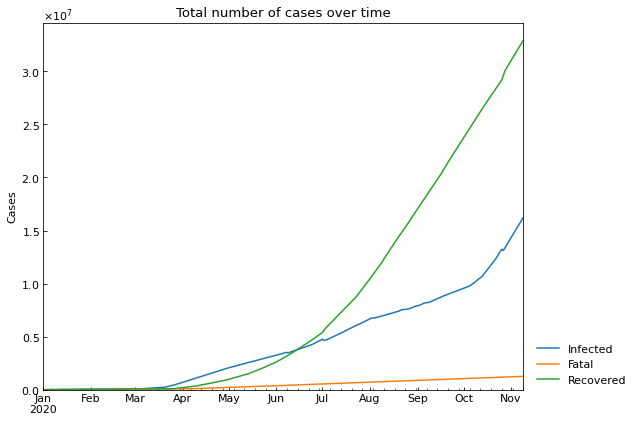

In [11]:
# Plot the total values
cs.line_plot(total_df[["Infected", "Fatal", "Recovered"]], "Total number of cases over time")

### (Optional) Replace the dataset in Japan
If we have dataset for each country, we can use it optionally.

In [12]:
# Registered data in jhu_data
jhu_data.subset("Japan").tail()

,Date,Confirmed,Infected,Fatal,Recovered
270,2020-11-05,104973,8075,1807,95091
271,2020-11-06,106114,8561,1811,95742
272,2020-11-07,107445,9184,1816,96445
273,2020-11-08,108399,9395,1823,97181
274,2020-11-09,109181,9716,1835,97630


In [13]:
# Download the dataset in Japan and show the citation
japan_data = data_loader.japan()
print(japan_data.citation)

Lisphilar (2020), COVID-19 dataset in Japan, GitHub repository, https://github.com/lisphilar/covid19-sir/data/japan


In [14]:
# Replace the dataset for Japan
jhu_data.replace(japan_data)
# Show the new records in Japan
jhu_data.subset("Japan").tail()

,Date,Confirmed,Infected,Fatal,Recovered
267,2020-11-04,102900,6819,1786,94295
268,2020-11-05,103838,6931,1794,95113
269,2020-11-06,104782,7220,1806,95756
270,2020-11-07,105914,7644,1809,96461
271,2020-11-08,107086,8077,1812,97197


### Population in each country
Population values are necessary to calculate the number of susceptible people. Susceptible is a variable of SIR-derived models.

In [15]:
# Description/citation
print(population_data.citation)

(Secondary source) Guidotti, E., Ardia, D., (2020), "COVID-19 Data Hub", Journal of Open Source Software 5(51):2376, doi: 10.21105/joss.02376.


In [16]:
# Raw data (the same as jhu_data)
population_data.raw.tail()

,ObservationDate,Confirmed,Recovered,Deaths,Population,ISO3,Province/State,Country/Region,school_closing,workplace_closing,cancel_events,gatherings_restrictions,transport_closing,stay_home_restrictions,internal_movement_restrictions,international_movement_restrictions,information_campaigns,testing_policy,contact_tracing,stringency_index
323729,2020-11-05,836,808,10,107808.0,COL,Vichada,Colombia,3,1,1,3,1,1,1,4,2,2,2,65.74
323730,2020-11-06,836,815,10,107808.0,COL,Vichada,Colombia,3,1,1,3,1,1,1,4,2,2,2,65.74
323731,2020-11-07,836,816,10,107808.0,COL,Vichada,Colombia,3,1,1,3,1,1,1,4,2,2,2,65.74
323732,2020-11-08,836,817,10,107808.0,COL,Vichada,Colombia,3,1,1,3,1,1,1,4,2,2,2,65.74
323733,2020-11-09,836,817,10,107808.0,COL,Vichada,Colombia,3,1,1,3,1,1,1,4,2,2,2,65.74


In [17]:
# Cleaned data
population_data.cleaned().tail()

,ISO3,Country,Province,Date,Population
273175,COL,Colombia,Vichada,2020-11-05,107808
273176,COL,Colombia,Vichada,2020-11-06,107808
273177,COL,Colombia,Vichada,2020-11-07,107808
273178,COL,Colombia,Vichada,2020-11-08,107808
273179,COL,Colombia,Vichada,2020-11-09,107808


In [18]:
population_data.value("Japan", province=None)

126529100

In [19]:
# Register population value of Tokyo in Japan
# https://www.metro.tokyo.lg.jp/tosei/hodohappyo/press/2020/06/11/07.html
population_data.update(14_002_973, "Japan", province="Tokyo")
population_data.value("Japan", province="Tokyo")

14002973

### Government Response Tracker (OxCGRT)
This will be used in [Usage (details: policy measures)](https://lisphilar.github.io/covid19-sir/usage_policy.html).

In [20]:
# Description/citation
print(oxcgrt_data.citation)

(Secondary source) Guidotti, E., Ardia, D., (2020), "COVID-19 Data Hub", Journal of Open Source Software 5(51):2376, doi: 10.21105/joss.02376.


In [21]:
# Raw data (the same as jhu_data)
oxcgrt_data.raw.tail()

,ObservationDate,Confirmed,Recovered,Deaths,Population,ISO3,Province/State,Country/Region,school_closing,workplace_closing,cancel_events,gatherings_restrictions,transport_closing,stay_home_restrictions,internal_movement_restrictions,international_movement_restrictions,information_campaigns,testing_policy,contact_tracing,stringency_index
323729,2020-11-05,836,808,10,107808.0,COL,Vichada,Colombia,3,1,1,3,1,1,1,4,2,2,2,65.74
323730,2020-11-06,836,815,10,107808.0,COL,Vichada,Colombia,3,1,1,3,1,1,1,4,2,2,2,65.74
323731,2020-11-07,836,816,10,107808.0,COL,Vichada,Colombia,3,1,1,3,1,1,1,4,2,2,2,65.74
323732,2020-11-08,836,817,10,107808.0,COL,Vichada,Colombia,3,1,1,3,1,1,1,4,2,2,2,65.74
323733,2020-11-09,836,817,10,107808.0,COL,Vichada,Colombia,3,1,1,3,1,1,1,4,2,2,2,65.74


In [22]:
# Cleaned data
oxcgrt_data.cleaned().tail()

,Date,Country,ISO3,School_closing,Workplace_closing,Cancel_events,Gatherings_restrictions,Transport_closing,Stay_home_restrictions,Internal_movement_restrictions,International_movement_restrictions,Information_campaigns,Testing_policy,Contact_tracing,Stringency_index
323729,2020-11-05,Colombia,COL,3,1,1,3,1,1,1,4,2,2,2,65.74
323730,2020-11-06,Colombia,COL,3,1,1,3,1,1,1,4,2,2,2,65.74
323731,2020-11-07,Colombia,COL,3,1,1,3,1,1,1,4,2,2,2,65.74
323732,2020-11-08,Colombia,COL,3,1,1,3,1,1,1,4,2,2,2,65.74
323733,2020-11-09,Colombia,COL,3,1,1,3,1,1,1,4,2,2,2,65.74


In [23]:
# Subset for a country
oxcgrt_data.subset("Japan").tail()

,Date,School_closing,Workplace_closing,Cancel_events,Gatherings_restrictions,Transport_closing,Stay_home_restrictions,Internal_movement_restrictions,International_movement_restrictions,Information_campaigns,Testing_policy,Contact_tracing,Stringency_index
309,2020-11-05,1,1,1,0,0,1,1,3,2,2,1,38.89
310,2020-11-06,1,1,1,0,0,1,1,3,2,2,1,38.89
311,2020-11-07,1,1,1,0,0,1,1,3,2,2,1,38.89
312,2020-11-08,1,1,1,0,0,1,1,3,2,2,1,38.89
313,2020-11-09,1,1,1,0,0,1,1,3,2,2,1,38.89


In [24]:
# Subset for a country (using ISO3 code)
oxcgrt_data.subset("JPN").tail()

,Date,School_closing,Workplace_closing,Cancel_events,Gatherings_restrictions,Transport_closing,Stay_home_restrictions,Internal_movement_restrictions,International_movement_restrictions,Information_campaigns,Testing_policy,Contact_tracing,Stringency_index
309,2020-11-05,1,1,1,0,0,1,1,3,2,2,1,38.89
310,2020-11-06,1,1,1,0,0,1,1,3,2,2,1,38.89
311,2020-11-07,1,1,1,0,0,1,1,3,2,2,1,38.89
312,2020-11-08,1,1,1,0,0,1,1,3,2,2,1,38.89
313,2020-11-09,1,1,1,0,0,1,1,3,2,2,1,38.89


## Scenario analysis
As an example, we will analysis the number of cases in Japan.

In [25]:
snl = cs.Scenario(jhu_data, population_data, country="Japan", province=None)

### Check records
Let's see the records at first. `Scenario.records()` method return the records as a pandas dataframe and show a line plot.

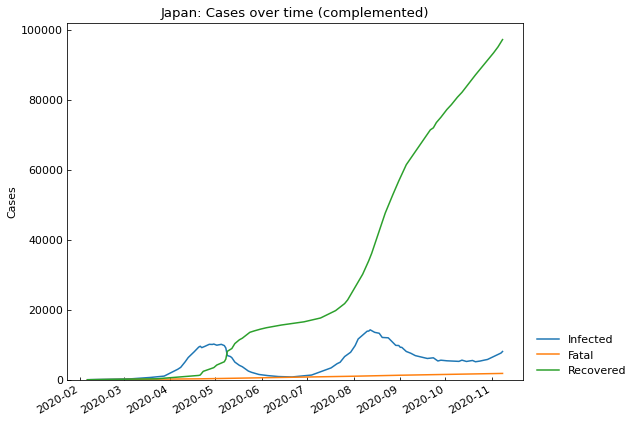

,Date,Confirmed,Infected,Fatal,Recovered
267,2020-11-04,102900,6819,1786,94295
268,2020-11-05,103838,6931,1794,95113
269,2020-11-06,104782,7220,1806,95756
270,2020-11-07,105914,7644,1809,96461
271,2020-11-08,107086,8077,1812,97197


In [26]:
record_df = snl.records()
record_df.tail()

### S-R trend analysis
S-R trend analysis finds the change points of SIR-derived ODE parameters. Details will be explained in [Usage (details: phases)](https://lisphilar.github.io/covid19-sir/usage_phases.html).

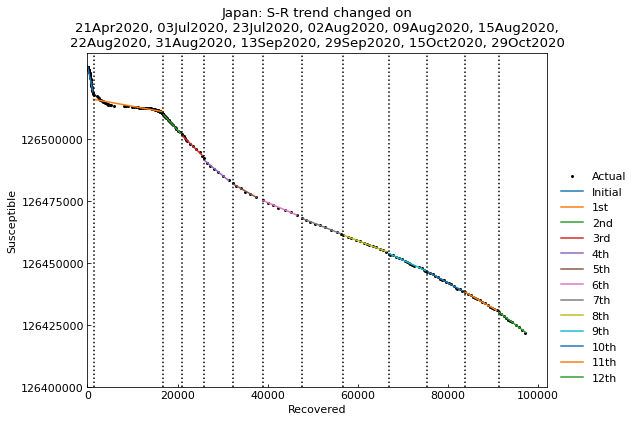

,Type,Start,End,Population
0th,Past,06Feb2020,20Apr2020,126529100
1st,Past,21Apr2020,02Jul2020,126529100
2nd,Past,03Jul2020,22Jul2020,126529100
3rd,Past,23Jul2020,01Aug2020,126529100
4th,Past,02Aug2020,08Aug2020,126529100
5th,Past,09Aug2020,14Aug2020,126529100
6th,Past,15Aug2020,21Aug2020,126529100
7th,Past,22Aug2020,30Aug2020,126529100
8th,Past,31Aug2020,12Sep2020,126529100
9th,Past,13Sep2020,28Sep2020,126529100


In [27]:
# Perform S-R trend analysis and set phases
snl.trend(set_phases=True)
snl.summary()

### Hyperparameter estimation of ODE models
Here, we will estimate the parameter values of SIR-derived models. As an example, we use SIR-F model. Details of models will be explained in [Usage (details: theoritical datasets)](https://lisphilar.github.io/covid19-sir/usage_theoretical.html).

In [28]:
# Estimate the parameter values of SIR-F model
snl.estimate(cs.SIRF)


<SIR-F model: parameter estimation>
Running optimization with 4 CPUs...


	12th phase (29Oct2020 - 08Nov2020): finished  376 trials in 0 min 15 sec


	 1st phase (21Apr2020 - 02Jul2020): finished  960 trials in 1 min  0 sec

	 2nd phase (03Jul2020 - 22Jul2020): finished 1004 trials in 1 min  0 sec

	 0th phase (06Feb2020 - 20Apr2020): finished  944 trials in 1 min  0 sec

	 3rd phase (23Jul2020 - 01Aug2020): finished 1061 trials in 1 min  0 sec

	 6th phase (15Aug2020 - 21Aug2020): finished  123 trials in 0 min  5 sec

	 7th phase (22Aug2020 - 30Aug2020): finished  118 trials in 0 min  5 sec

	 8th phase (31Aug2020 - 12Sep2020): finished  223 trials in 0 min 10 sec

	 9th phase (13Sep2020 - 28Sep2020): finished  224 trials in 0 min 10 sec

	11th phase (15Oct2020 - 28Oct2020): finished  175 trials in 0 min 10 sec

	 4th phase (02Aug2020 - 08Aug2020): finished 1099 trials in 1 min  0 sec

	 5th phase (09Aug2020 - 14Aug2020): finished 1101 trials in 1 min  0 sec

	10th phase (29Sep2020 - 14Oct2020): finished 1151 trials in 1 min  0 sec

Completed optimization. Total: 2 min 32 sec


In [29]:
# Show the sumamry of parameter estimation
snl.summary()

,Type,Start,End,Population,ODE,Rt,theta,kappa,rho,sigma,tau,1/beta [day],1/gamma [day],1/alpha2 [day],alpha1 [-],RMSLE,Trials,Runtime
0th,Past,06Feb2020,20Apr2020,126529100,SIR-F,7.13,0.020687,0.000112,0.049105,0.006628,720,10,75,4452,0.021,1.128845,944,1 min 0 sec
1st,Past,21Apr2020,02Jul2020,126529100,SIR-F,0.40,0.081582,0.000594,0.015191,0.034226,720,32,14,842,0.082,0.766968,960,1 min 0 sec
2nd,Past,03Jul2020,22Jul2020,126529100,SIR-F,2.02,0.000637,0.000117,0.073720,0.036280,720,6,13,4288,0.001,0.045108,1004,1 min 0 sec
3rd,Past,23Jul2020,01Aug2020,126529100,SIR-F,1.97,0.000589,0.000114,0.066524,0.033642,720,7,14,4397,0.001,0.033520,1061,1 min 0 sec
4th,Past,02Aug2020,08Aug2020,126529100,SIR-F,1.65,0.001058,0.000069,0.060355,0.036554,720,8,13,7223,0.001,0.032450,1099,1 min 0 sec
5th,Past,09Aug2020,14Aug2020,126529100,SIR-F,1.10,0.000739,0.000225,0.041999,0.037757,720,11,13,2222,0.001,0.012545,1101,1 min 0 sec
6th,Past,15Aug2020,21Aug2020,126529100,SIR-F,0.72,0.000488,0.000526,0.037588,0.051460,720,13,9,950,0.000,0.026477,123,0 min 5 sec
7th,Past,22Aug2020,30Aug2020,126529100,SIR-F,0.64,0.000488,0.000526,0.034478,0.053088,720,14,9,950,0.000,0.048876,118,0 min 5 sec
8th,Past,31Aug2020,12Sep2020,126529100,SIR-F,0.63,0.001455,0.000747,0.033992,0.053239,720,14,9,669,0.001,0.045906,223,0 min 10 sec
9th,Past,13Sep2020,28Sep2020,126529100,SIR-F,0.84,0.001468,0.000595,0.037305,0.043851,720,13,11,839,0.001,0.029493,224,0 min 10 sec


### Accuracy of estimation

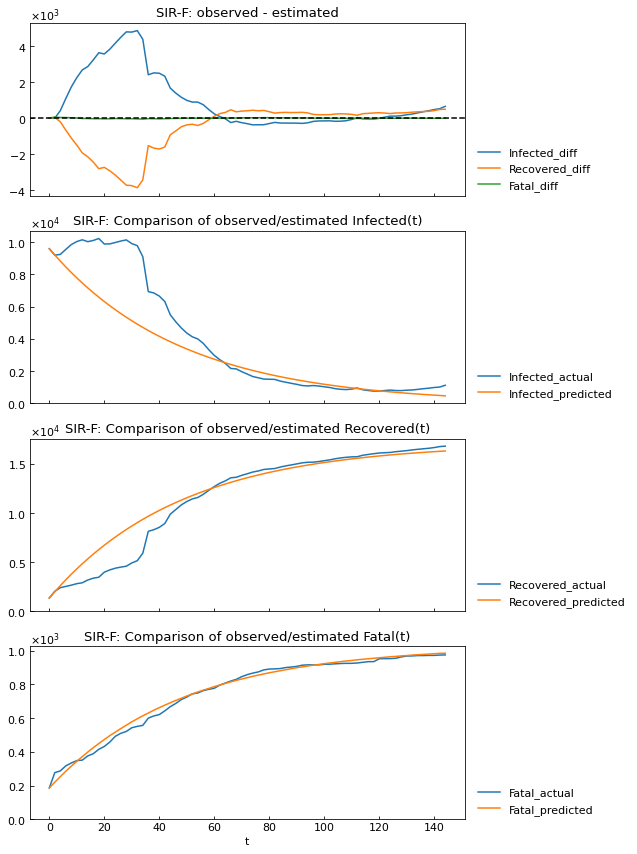

In [30]:
snl.estimate_accuracy(phase="1st")

### Get parameter value

In [31]:
snl.get("Rt", phase="4th")

1.65

### Show parameter history

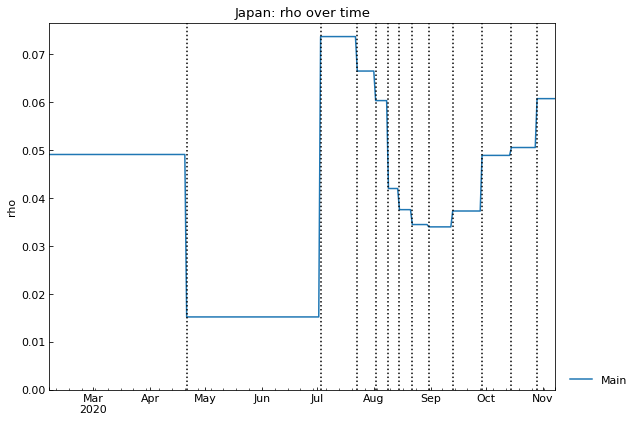

In [32]:
_ = snl.history(target="rho")

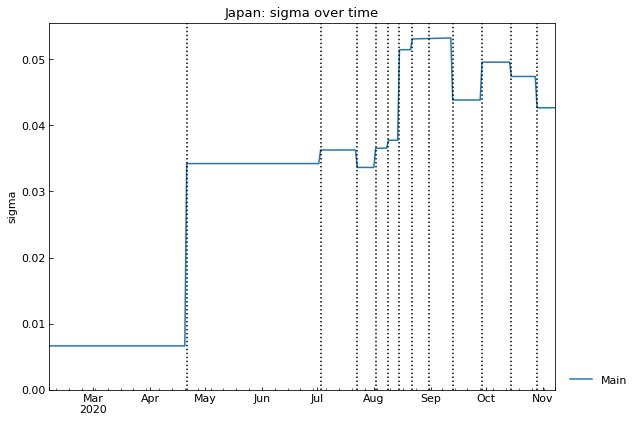

In [33]:
_ = snl.history(target="sigma")

### Show the history of reproduction number

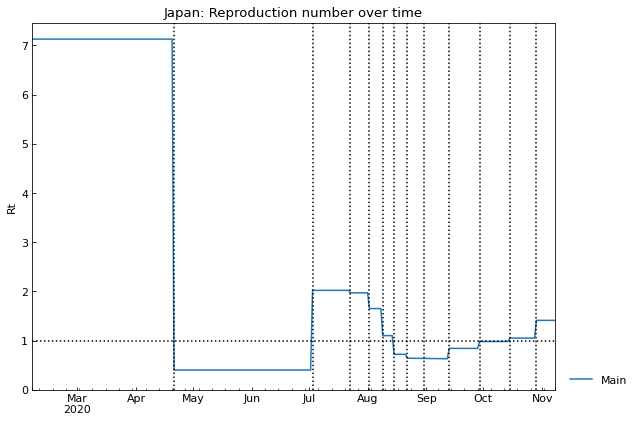

In [34]:
_ = snl.history(target="Rt")

### Simulate the number of cases

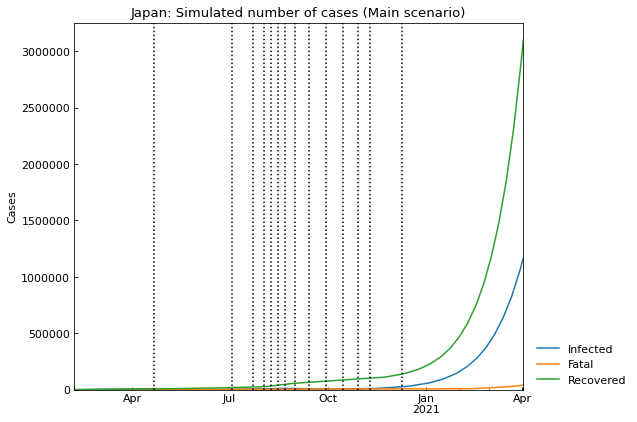

,Date,Confirmed,Fatal,Infected,Recovered
417,2021-03-29,3790340,35774,1030165,2724401
418,2021-03-30,3913651,36925,1063006,2813720
419,2021-03-31,4040754,38112,1096762,2905880
420,2021-04-01,4171746,39336,1131449,3000961
421,2021-04-02,4306724,40598,1167084,3099042


In [35]:
snl.clear(name="Main")
snl.add(days=30)
snl.add(end_date="01Apr2021", name="Main")
main_sim_df = snl.simulate(name="Main")
main_sim_df.tail()

### Simulate another scenario
If $\sigma$ will be double in 30 days, how many cases will be?

In [36]:
sigma_current = snl.get("sigma", name="Main", phase="last")
sigma_current

0.042673948838575344

In [37]:
sigma_new = sigma_current * 2
sigma_new

0.08534789767715069

In [38]:
snl.clear(name="Medicine")
snl.add(name="Medicine", days=30, sigma=sigma_current)
snl.add(name="Medicine", end_date="01Apr2021", sigma=sigma_new)
snl.summary()

Type      Start        End  Population    ODE    Rt  \
Scenario Phase                                                          
Main     0th      Past  06Feb2020  20Apr2020   126529100  SIR-F  7.13   
         1st      Past  21Apr2020  02Jul2020   126529100  SIR-F  0.40   
         2nd      Past  03Jul2020  22Jul2020   126529100  SIR-F  2.02   
         3rd      Past  23Jul2020  01Aug2020   126529100  SIR-F  1.97   
         4th      Past  02Aug2020  08Aug2020   126529100  SIR-F  1.65   
         5th      Past  09Aug2020  14Aug2020   126529100  SIR-F  1.10   
         6th      Past  15Aug2020  21Aug2020   126529100  SIR-F  0.72   
         7th      Past  22Aug2020  30Aug2020   126529100  SIR-F  0.64   
         8th      Past  31Aug2020  12Sep2020   126529100  SIR-F  0.63   
         9th      Past  13Sep2020  28Sep2020   126529100  SIR-F  0.84   
         10th     Past  29Sep2020  14Oct2020   126529100  SIR-F  0.98   
         11th     Past  15Oct2020  28Oct2020   126529100  SIR-F  1.05   
         12th     Past  29Oct2020  08Nov2020   126529100  SIR-F  1.41   
         13th   Future  09Nov2020  08Dec2020   126529100  SIR-F  1.41   
         14th   Future  09Dec2020  01Apr2021   126529100  SIR-F  1.41   
Medicine 0th      Past  06Feb2020  20Apr2020   126529100  SIR-F  7.13   
         1st      Past  21Apr2020  02Jul2020   126529100  SIR-F  0.40   
         2nd      Past  03Jul2020  22Jul2020   126529100  SIR-F  2.02   
         3rd      Past  23Jul2020  01Aug2020   126529100  SIR-F  1.97   
         4th      Past  02Aug2020  08Aug2020   126529100  SIR-F  1.65   
         5th      Past  09Aug2020  14Aug2020   126529100  SIR-F  1.10   
         6th      Past  15Aug2020  21Aug2020   126529100  SIR-F  0.72   
         7th      Past  22Aug2020  30Aug2020   126529100  SIR-F  0.64   
         8th      Past  31Aug2020  12Sep2020   126529100  SIR-F  0.63   
         9th      Past  13Sep2020  28Sep2020   126529100  SIR-F  0.84   
         10th     Past  29Sep2020  14Oct2020   126529100  SIR-F  0.98   
         11th     Past  15Oct2020  28Oct2020   126529100  SIR-F  1.05   
         12th     Past  29Oct2020  08Nov2020   126529100  SIR-F  1.41   
         13th   Future  09Nov2020  08Dec2020   126529100  SIR-F  1.41   
         14th   Future  09Dec2020  01Apr2021   126529100  SIR-F  0.71   

                   theta     kappa       rho     sigma  tau  1/beta [day]  \
Scenario Phase                                                              
Main     0th    0.020687  0.000112  0.049105  0.006628  720            10   
         1st    0.081582  0.000594  0.015191  0.034226  720            32   
         2nd    0.000637  0.000117  0.073720  0.036280  720             6   
         3rd    0.000589  0.000114  0.066524  0.033642  720             7   
         4th    0.001058  0.000069  0.060355  0.036554  720             8   
         5th    0.000739  0.000225  0.041999  0.037757  720            11   
         6th    0.000488  0.000526  0.037588  0.051460  720            13   
         7th    0.000488  0.000526  0.034478  0.053088  720            14   
         8th    0.001455  0.000747  0.033992  0.053239  720            14   
         9th    0.001468  0.000595  0.037305  0.043851  720            13   
         10th   0.000078  0.000555  0.048916  0.049575  720            10   
         11th   0.000350  0.000708  0.050560  0.047410  720             9   
         12th   0.002135  0.000424  0.060764  0.042674  720             8   
         13th   0.002135  0.000424  0.060764  0.042674  720             8   
         14th   0.002135  0.000424  0.060764  0.042674  720             8   
Medicine 0th    0.020687  0.000112  0.049105  0.006628  720            10   
         1st    0.081582  0.000594  0.015191  0.034226  720            32   
         2nd    0.000637  0.000117  0.073720  0.036280  720             6   
         3rd    0.000589  0.000114  0.066524  0.033642  720             7   
         4th    0.001058  0.000069  0.060355  0.036554  720     

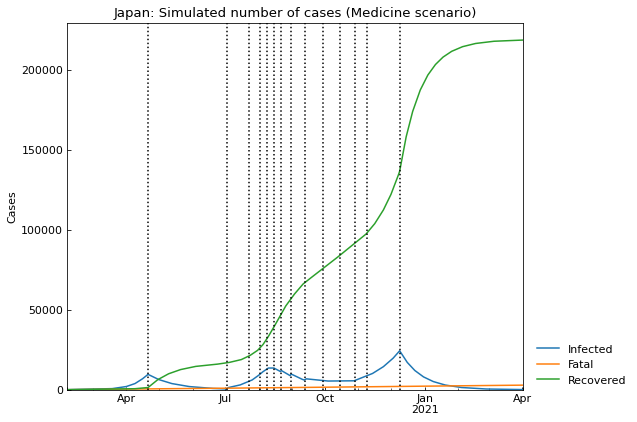

,Date,Confirmed,Fatal,Infected,Recovered
417,2021-03-29,221338,2850,95,218393
418,2021-03-30,221349,2850,90,218409
419,2021-03-31,221360,2850,86,218424
420,2021-04-01,221369,2850,81,218438
421,2021-04-02,221379,2850,77,218452


In [39]:
snl.simulate(name="Medicine").tail()

### Compare the scenarios
We will compare the scenarios with representative values, reproduction number and parameter values.

In [40]:
snl.describe()

,max(Infected),argmax(Infected),Confirmed on 02Apr2021,Infected on 02Apr2021,Fatal on 02Apr2021,14th_Rt
Main,1167084,02Apr2021,4306724,1167084,40598,1.41
Medicine,24300,09Dec2020,221379,77,2850,0.71


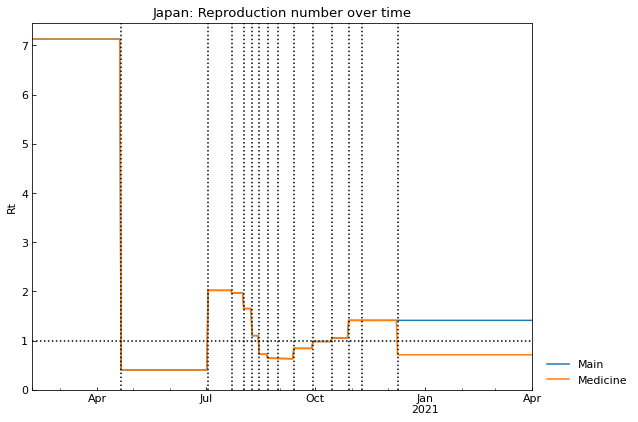

In [41]:
_ = snl.history(target="Rt")

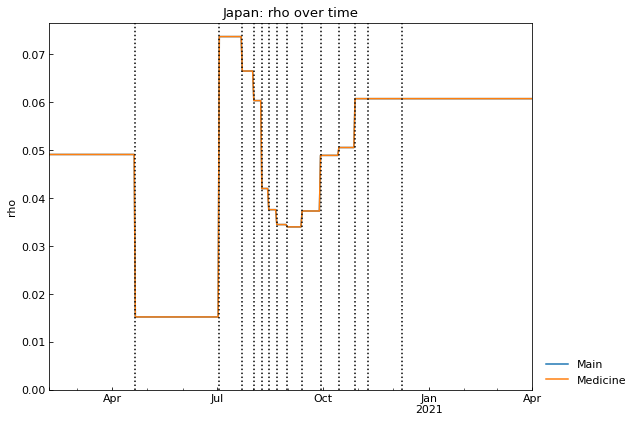

In [42]:
_ = snl.history(target="rho")

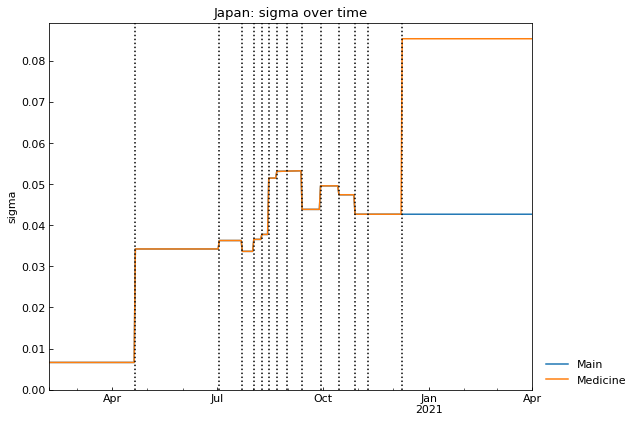

In [43]:
_ = snl.history(target="sigma")

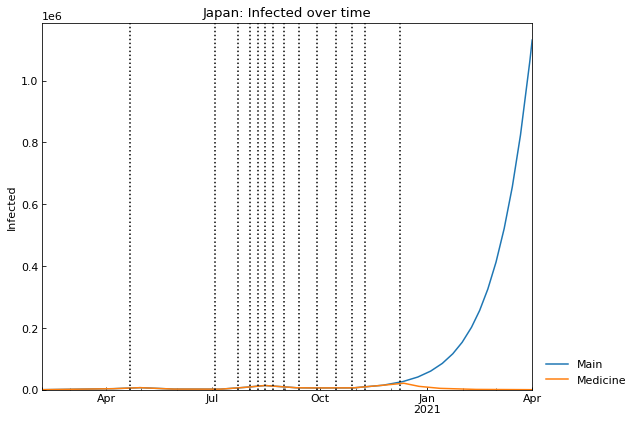

In [44]:
_ = snl.history(target="Infected")

### Change rate of parameters in main scenario
History of each parameter will be shown. Values will be divided by the values in 0th phase.

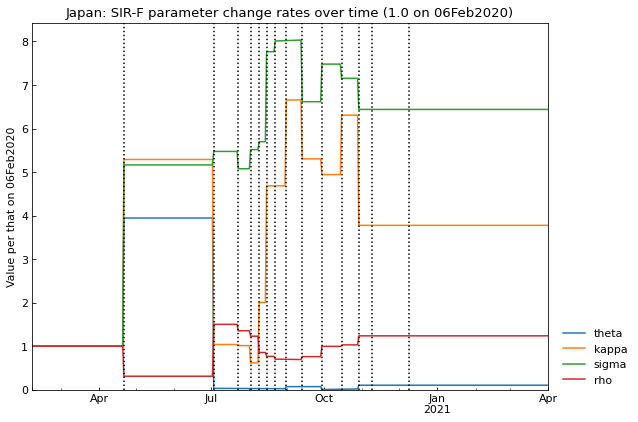

In [45]:
_ = snl.history_rate(name="Main")

## Retrospective analysis
We can evaluate the impact of measures using past records. How many people were infected if the parameter values have not changed sinse 01Sep2020?

In [46]:
# Perform retrospective analysis
snl_retro = cs.Scenario(jhu_data, population_data, "Japan")
snl_retro.retrospective("01Sep2020", model=cs.SIRF, control="Main", target="Retrospective")


<SIR-F model: parameter estimation>
Running optimization with 4 CPUs...


	12th phase (29Oct2020 - 08Nov2020): finished  409 trials in 0 min 20 sec


	 1st phase (21Apr2020 - 02Jul2020): finished 1009 trials in 1 min  0 sec

	 2nd phase (03Jul2020 - 22Jul2020): finished 1039 trials in 1 min  0 sec

	 3rd phase (23Jul2020 - 01Aug2020): finished 1034 trials in 1 min  0 sec

	 0th phase (06Feb2020 - 20Apr2020): finished  996 trials in 1 min  0 sec

	 6th phase (15Aug2020 - 21Aug2020): finished  126 trials in 0 min  5 sec

	 7th phase (22Aug2020 - 30Aug2020): finished  126 trials in 0 min  5 sec

	 8th phase (31Aug2020 - 12Sep2020): finished  228 trials in 0 min 10 sec

	 9th phase (13Sep2020 - 28Sep2020): finished  231 trials in 0 min 10 sec

	11th phase (15Oct2020 - 28Oct2020): finished  474 trials in 0 min 20 sec

	 4th phase (02Aug2020 - 08Aug2020): finished 1141 trials in 0 min 55 sec

	 5th phase (09Aug2020 - 14Aug2020): finished 1255 trials in 1 min  0 sec

	10th phase (29Sep2020 - 14Oct2020): finished 1334 trials in 1 min  0 sec

Completed optimization. Total: 2 min 36 sec



<SIR-F model: parameter estimation>
Running optimization with 4 CPUs...


	 8th phase (31Aug2020 - 08Nov2020): finished 3214 trials in 1 min  0 sec

Completed optimization. Total: 1 min  0 sec


In [47]:
# Show the summary of estimation
cols = ["Start", "End", "ODE", "Rt", *cs.SIRF.PARAMETERS] + ["RMSLE", "Trials", "Runtime"]
snl_retro.summary(columns=cols)

Start        End    ODE    Rt     theta     kappa  \
Scenario      Phase                                                          
Main          0th    06Feb2020  20Apr2020  SIR-F  7.13  0.020687  0.000112   
              1st    21Apr2020  02Jul2020  SIR-F  0.40  0.081582  0.000594   
              2nd    03Jul2020  22Jul2020  SIR-F  2.02  0.000637  0.000117   
              3rd    23Jul2020  01Aug2020  SIR-F  1.97  0.000589  0.000114   
              4th    02Aug2020  08Aug2020  SIR-F  1.66  0.000153  0.000177   
              5th    09Aug2020  14Aug2020  SIR-F  1.10  0.000739  0.000225   
              6th    15Aug2020  21Aug2020  SIR-F  0.72  0.000488  0.000526   
              7th    22Aug2020  30Aug2020  SIR-F  0.64  0.000488  0.000526   
              8th    31Aug2020  12Sep2020  SIR-F  0.63  0.001455  0.000747   
              9th    13Sep2020  28Sep2020  SIR-F  0.84  0.001468  0.000595   
              10th   29Sep2020  14Oct2020  SIR-F  0.98  0.000789  0.000519   
              11th   15Oct2020  28Oct2020  SIR-F  1.06  0.000172  0.000619   
              12th   29Oct2020  08Nov2020  SIR-F  1.41  0.002135  0.000424   
Retrospective 0th    06Feb2020  20Apr2020  SIR-F  7.13  0.020687  0.000112   
              1st    21Apr2020  02Jul2020  SIR-F  0.40  0.081582  0.000594   
              2nd    03Jul2020  22Jul2020  SIR-F  2.02  0.000637  0.000117   
              3rd    23Jul2020  01Aug2020  SIR-F  1.97  0.000589  0.000114   
              4th    02Aug2020  08Aug2020  SIR-F  1.66  0.000153  0.000177   
              5th    09Aug2020  14Aug2020  SIR-F  1.10  0.000739  0.000225   
              6th    15Aug2020  21Aug2020  SIR-F  0.72  0.000488  0.000526   
              7th    22Aug2020  30Aug2020  SIR-F  0.64  0.000488  0.000526   
              8th    31Aug2020  08Nov2020  SIR-F  0.64  0.000488  0.000526   

                          rho     sigma     RMSLE  Trials       Runtime  
Scenario      Phase                                                      
Main          0th    0.049105  0.006628  1.128845     996  1 min  0 sec  
              1st    0.015191  0.034226  0.766968    1009  1 min  0 sec  
              2nd    0.073720  0.036280  0.045108    1039  1 min  0 sec  
              3rd    0.066524  0.033642  0.033520    1034  1 min  0 sec  
              4th    0.060357  0.036087  0.031445    1141  0 min 55 sec  
              5th    0.041999  0.037757  0.012545    1255  1 min  0 sec  
              6th    0.037588  0.051460  0.026477     126  0 min  5 sec  
              7th    0.034478  0.053088  0.048876     126  0 min  5 sec  
              8th    0.033992  0.053239  0.045906     228  0 min 10 sec  
              9th    0.037305  0.043851  0.029493     231  0 min 10 sec  
              10th   0.049229  0.049700  0.018094    1334  1 min  0 sec  
              11th   0.050529  0.047095  0.023259     474  0 min 20 sec  
              12th   0.060764  0.042674  0.025667     409  0 min 20 sec  
Retrospective 0th    0.049105  0.006628  1.128845     996  1 min  0 sec  
              1st    0.015191  0.034226  0.766968    1009  1 min  0 sec  
              2nd    0.073720  0.036280  0.045108    1039  1 min  0 sec  
              3rd    0.066524  0.033642  0.033520    1034  1 min  0 sec  
              4th    0.060357  0.036087  0.031445    1141  0 min 55 sec  
              5th    0.041999  0.037757  0.012545    1255  1 min  0 sec  
              6th    0.037588  0.051460  0.026477     126  0 min  5 sec  
              7th    0.034478  0.053088  0.048876     126  0 min  5 sec  
              8th    0.034478  0.053088  2.042610    3214  1 min  0 sec

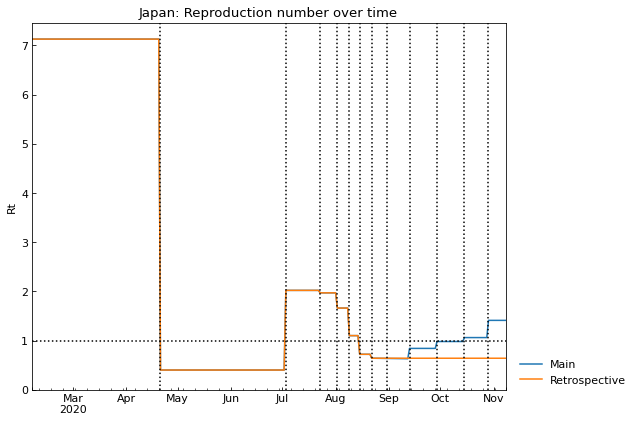

In [48]:
# History of reproduction number
_ = snl_retro.history("Rt")

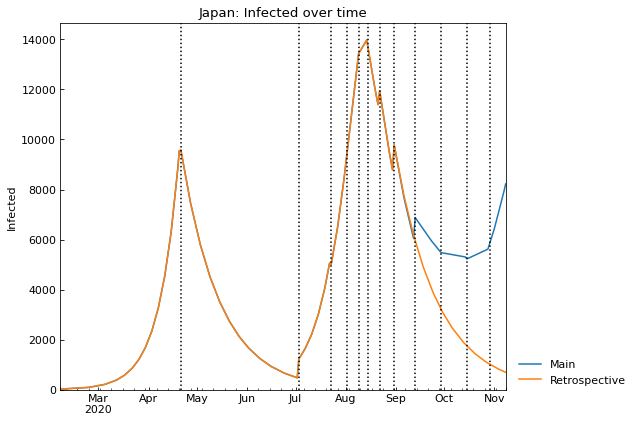

In [49]:
# History of Infected
_ = snl_retro.history("Infected")

In [50]:
# Show the representative values
snl_retro.describe()

,max(Infected),argmax(Infected),Confirmed on 09Nov2020,Infected on 09Nov2020,Fatal on 09Nov2020,8th_Rt,9th_Rt,10th_Rt,11th_Rt,12th_Rt
Main,13975,14Aug2020,108296,8517,1819,0.63,0.84,0.98,1.06,1.41
Retrospective,13975,14Aug2020,84244,670,1537,0.64,-,-,-,-
